# Optimization of box production

In [20]:
# to be installed ...
!pip install dimod
!pip install cplex
!pip install docplex

!pip install qiskit_optimization

In [21]:
##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#
import dimod

#
import docplex.mp
import cplex
from docplex.mp.advmodel import AdvModel as Model

#
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer


from qiskit_algorithms.optimizers import COBYLA



from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import (
    InequalityToEquality,
    LinearEqualityToPenalty,
    IntegerToBinary,
    QuadraticProgramToQubo)


### Optimization problem


In [22]:
# Papier/Pappe, Reinfiorce, Lined, Colored

b = np.array([50,10,20,30])

C=np.array([[0,-30,0,0],[-30,0,-30,0],[0,-30,0,40],[0,0,40,0]])

print("b=",b)
print()
print(C)

b= [50 10 20 30]

[[  0 -30   0   0]
 [-30   0 -30   0]
 [  0 -30   0  40]
 [  0   0  40   0]]


Maximize $H$:

\begin{align} H=\frac{1}{2}\mathbf{a}^T\mathbf{C}\mathbf{a} + \mathbf{b}^T\mathbf{a}\end{align}




**Q**uadratic **U**nconstrained **B**inary **O**ptimization

Problem:

\begin{align} H=\sum_{i<j} C_{ij}a_i a_j + \sum_{i} b_i a_i \text{ mit } \forall a_i \in {0,1} \text{ und } C_{ij} \in \mathbb{R},b_i \in \mathbb{R} \end{align}

Minimize instead of Maximize:

$ b \rightarrow -b $ und  $ C \rightarrow -C $


Try all $ [0,1]^4$  combinations by brute force. Use "ExactSolver" from the Python  package dimod:

   Cardbox Colored Lined Reinforced energy num_oc.
9        1       1     1          0 -140.0       1
8        0       1     1          0  -90.0       1
10       1       1     1          1  -90.0       1
14       1       1     0          0  -80.0       1
6        1       0     1          0  -70.0       1
11       0       1     1          1  -70.0       1
13       1       1     0          1  -60.0       1
1        1       0     0          0  -50.0       1
12       0       1     0          1  -40.0       1
2        1       0     0          1  -30.0       1
15       0       1     0          0  -30.0       1
5        1       0     1          1  -20.0       1
7        0       0     1          0  -20.0       1
3        0       0     0          1  -10.0       1
0        0       0     0          0    0.0       1
4        0       0     1          1    0.0       1
['BINARY', 16 rows, 16 samples, 4 variables]


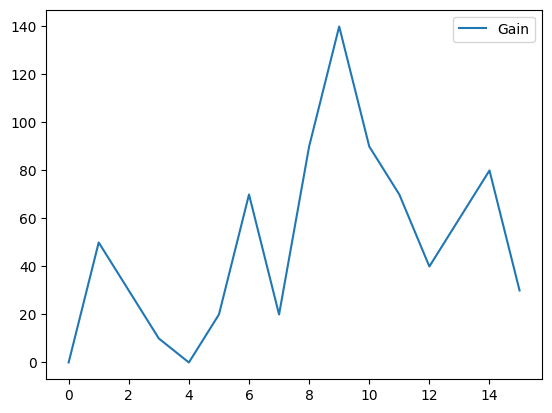

In [23]:
bqm=dimod.BinaryQuadraticModel(-b,-C/2,dimod.BINARY)
bqm.relabel_variables({0:"Cardbox",1:"Reinforced",2:"Lined",3:"Colored"})

solver = dimod.ExactSolver()
solutions = solver.sample(bqm)

print(solutions)

erloes =-solutions.to_pandas_dataframe()
erloes=erloes.rename(columns={'energy': 'Gain'})
_=erloes.plot(y="Gain")

### Classical Solution via CPLEX:

In [24]:


comp=["Cardbox","Reinforced","Lined","Colored"]
df_comp=pd.DataFrame()

df_comp = pd.DataFrame(b,columns=['b'])
df_comp.index = ["Cardbox","Reinforced","Lined","Colored"]

C=pd.DataFrame(C/2,columns=["Cardbox","Reinforced","Lined","Colored"],index=["Cardbox","Reinforced","Lined","Colored"])
C

,Cardbox,Reinforced,Lined,Colored
Cardbox,0.0,-15.0,0.0,0.0
Reinforced,-15.0,0.0,-15.0,0.0
Lined,0.0,-15.0,0.0,20.0
Colored,0.0,0.0,20.0,0.0


In [25]:
## D
mdl = Model(name='Optimiere_Schachtel')

##
df_comp['bin'] = mdl.binary_var_list(comp, name='bin')


##
gain1 = mdl.dot(df_comp.bin,df_comp.b)

##
bini = df_comp.bin
gain2 = mdl.sum((float(C[s1][s2]) * bini[s1] * bini[s2]) for s1 in df_comp.index for s2 in df_comp.index)

#
obj=gain1+gain2

##
mdl.minimize(-obj)

mdl.prettyprint()

assert mdl.solve(url=None, key=None), "Solve failed"

mdl.report()
sol=mdl.solution.get_objective_value()
print("Solution:",sol)

Solution=[]
for i in range(4):
    Solution.append(df_comp['bin'].iloc[i].solution_value)

print(df_comp['bin'].values)
print("Bitstring:",Solution)


// This file has been generated by DOcplex
// model name is: Optimiere_Schachtel
// var contrainer section
dvar bool bin[4];

minimize
 - 50 bin_Cardbox - 10 bin_Reinforced - 20 bin_Lined - 30 bin_Colored [
 30 bin_Cardbox*bin_Reinforced + 30 bin_Reinforced*bin_Lined
 - 40 bin_Lined*bin_Colored ];
 
subject to {

}
* model Optimiere_Schachtel solved with objective = -140.000
Solution: -140.0
[bin_Cardbox bin_Reinforced bin_Lined bin_Colored]
Bitstring: [1.0, 0, 1.0, 1.0]


#### Result:

Same solution as with brute force!

## Demo: Optimization via Quantum Computing

In [26]:

def index_to_selection(i):
    s = "{0:b}".format(i).rjust(4)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(4))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

#### Good news:

We can use QAOA out-of-the box, e.g. from Qiskit (IBM)

In [27]:
#
qp = from_docplex_mp(mdl)

#
op,offset=op, offset = qp.to_ising()
print("Konstante:",offset)
print("Matrix:",op)

Konstante: -50.0
Matrix: SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZZI', 'ZZII'],
              coeffs=[ 17.5+0.j, -10. +0.j,  12.5+0.j,  25. +0.j,   7.5+0.j,   7.5+0.j,
 -10. +0.j])


dim(H): (16, 16)
---------------------------------------------------------
Matrix H:
[[ 50.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.  40.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.  20.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0. -20.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.  50.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -30.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0

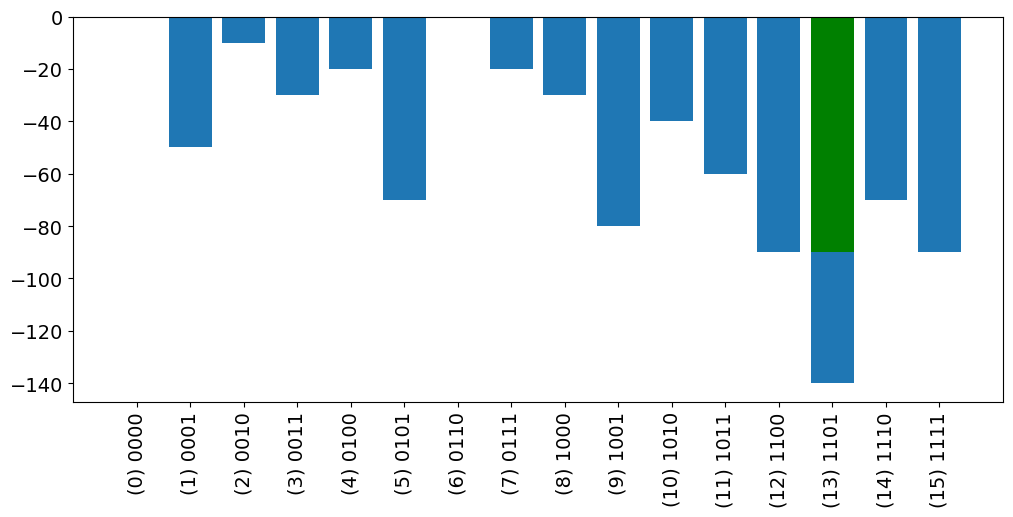

In [32]:
# Spectrum of the Hamiltonian
H=op
n=4
#
H_matrix = np.real(H.to_matrix())
print('dim(H):', H_matrix.shape)
print("---------------------------------------------------------")
print("Matrix H:")
print(H_matrix)
print("---------------------------------------------------------")
print("Diagonal element of matrix H= Eigenvalues")
print(H_matrix.diagonal()+offset)
print("---------------------------------------------------------")
# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), H_matrix.diagonal()+offset)
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:04b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

See: Optimal solution with -140 and bitstring [1,0,1,1] !!

In [29]:
from qiskit.primitives import Sampler

qaoa_mes = QAOA(sampler=Sampler(), reps=1, optimizer=COBYLA())

qaoa = MinimumEigenOptimizer(qaoa_mes)
result_qaoa = qaoa.solve(qp)

print(result_qaoa)
print()
print(result_qaoa.samples)

<ipython-input-29-a511bc996f0a>:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), reps=1, optimizer=COBYLA())


fval=-140.0, bin_Cardbox=1.0, bin_Reinforced=0.0, bin_Lined=1.0, bin_Colored=1.0, status=SUCCESS

[SolutionSample(x=array([1., 0., 1., 1.]), fval=np.float64(-140.0), probability=np.float64(0.5627691416071012), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 0., 1., 1.]), fval=np.float64(-90.0), probability=np.float64(0.0168872353365072), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 1., 1., 1.]), fval=np.float64(-90.0), probability=np.float64(0.116644457825111), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 0., 1.]), fval=np.float64(-80.0), probability=np.float64(0.0615489803605876), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 1., 0.]), fval=np.float64(-70.0), probability=np.float64(0.0075955550273003), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 1., 1., 1.]), fval=np.float64(-70.0), probability=np.float64(0.0446777425109134), status

Approximation Ratio: (Value-Worst_Value)*Probability/(Best_Value-Worst_Value)

We expect that approx.value converges to 1 as reps become bigger!

In [30]:
f_best=-140
f_worst=0

uu=0
r=0
for i in range(len(result_qaoa.samples)):
 r+=(result_qaoa.samples[i].fval-f_worst)/(f_best-f_worst)*result_qaoa.samples[i].probability
 uu+=result_qaoa.samples[i].probability
print('-----------------------------')
print(uu)
print("Approx.Ratio:",r/uu)

-----------------------------
0.9999999999999991
Approx.Ratio: 0.7732629843158189


In [31]:
from qiskit.primitives import Sampler

qaoa_mes = QAOA(sampler=Sampler(), reps=5, optimizer=COBYLA())#, initial_point=[0.0, 0.0])

qaoa = MinimumEigenOptimizer(qaoa_mes)
result_qaoa = qaoa.solve(qp)

print(result_qaoa)
print()
print(result_qaoa.samples)

uu=0
r=0
for i in range(len(result_qaoa.samples)):
 r+=(result_qaoa.samples[i].fval-f_worst)/(f_best-f_worst)*result_qaoa.samples[i].probability
 uu+=result_qaoa.samples[i].probability
print('-----------------------------')
print(uu)
print("Approx.Ratio:",r/uu)

<ipython-input-31-fb3aeb4ca28f>:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), reps=5, optimizer=COBYLA())#, initial_point=[0.0, 0.0])


fval=-140.0, bin_Cardbox=1.0, bin_Reinforced=0.0, bin_Lined=1.0, bin_Colored=1.0, status=SUCCESS

[SolutionSample(x=array([1., 0., 1., 1.]), fval=np.float64(-140.0), probability=np.float64(0.3114569666967526), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 0., 1., 1.]), fval=np.float64(-90.0), probability=np.float64(0.0897887873562686), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 1., 1., 1.]), fval=np.float64(-90.0), probability=np.float64(0.3245697373630948), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 0., 1.]), fval=np.float64(-80.0), probability=np.float64(0.0047570771945934), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 1., 0.]), fval=np.float64(-70.0), probability=np.float64(0.0517017645613066), status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 1., 1., 1.]), fval=np.float64(-70.0), probability=np.float64(0.0356652356033824), statu